In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from dataclasses import dataclass
import seaborn as sns

In [2]:
np.random.seed(123)
np.set_printoptions(suppress=True) # Removes printing of scientific notation values
sns.set_theme()
sns.set_palette("viridis")

## Helper functions

In [6]:
def distribution_plot(data1, data2, data3):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(18, 6)
    ax1.set_title("Distribution of Lever 1")
    ax2.set_title("Distribution of Lever 2")
    ax3.set_title("Distribution of Lever 3")
    ax1.set_xlabel('$x$')
    ax2.set_xlabel('$x$')
    ax3.set_xlabel('$x$')
    ax1.set_ylabel('Counts')
    ax1.hist(data1, color='c', bins=50)
    ax1.text(0.05, 0.95, fr"$\mu$={data1.mean()}", transform=ax1.transAxes, fontsize=14)
    ax2.hist(data2, color='c', bins=50)
    ax2.text(0.05, 0.95, fr"$\mu$={data2.mean()}", transform=ax2.transAxes, fontsize=14)
    ax3.hist(data3, color='c', bins=50)
    ax3.text(0.05, 0.95, fr"$\mu$={data3.mean()}", transform=ax3.transAxes, fontsize=14)
    plt.show()


def reward_comparison_plot(data1, data2, data3):
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 8)
    ax.set_title(fr"Accumalated Reward averaged over time for varying $\varepsilon$")
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Accumulated Reward')
    
    x = [i+1 for i in range(len(data1))]
    
    ax.plot(x, data1, label=r'$\varepsilon$ = 0')
    ax.plot(x, data2, label=r'$\varepsilon$ = 0.1')
    ax.plot(x, data3, label=r'$\varepsilon$ = 0.3')
    
    plt.legend()
    plt.show()

Consider 3 slot machines with a lever with a normal distribution (variance = 1) with their means being 0, 1, 2. 
If the levers were to be pulled 1 000 times, let us look at the plot.

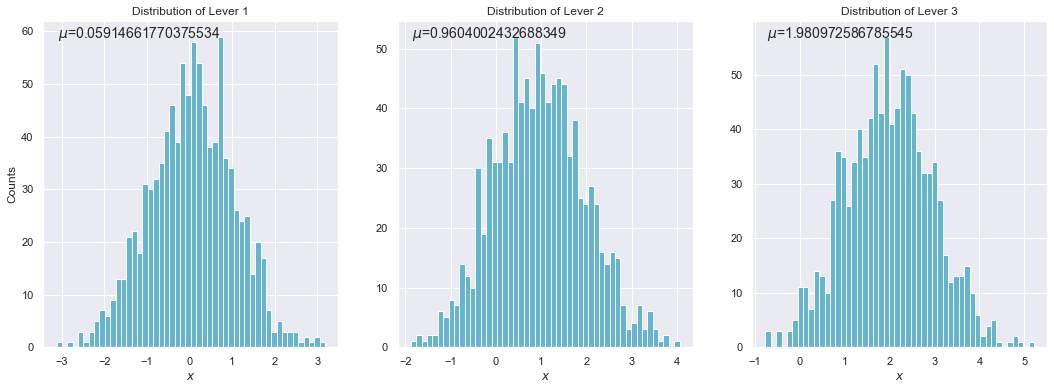

In [17]:
lever_1 = np.random.normal(0, 1, 1000)
lever_2 = np.random.normal(1, 1, 1000)
lever_3 = np.random.normal(2, 1, 1000)
distribution_plot(lever_1, lever_2, lever_3)

The value function $Q(a)$ can be estimated more efficiently using the following stochastic approximation:
$$
Q_n(a) = (1 - \alpha_n)Q_{n-1}(a) + \alpha_nR_n
$$
for the realised action $A_n = a$ at time n and
$$
Q_n(a') = Q_{n-1}(a')
$$
for all other actions $a' \neq a$. Here $\alpha_n = \frac{1}{n}$ is the annealing sequence.

Plot the accumulated reward averaged over time for different values of $\varepsilon$.

In [18]:
def compute_values(action: int, reward: float, prev_values: np.ndarray, n: int) -> np.ndarray:
    """
    This function computes the value function as defined above every time a new action is picked.

    Args:
        action: 0, 1 or 2 representing which lever was pulled
        reward: sample from the machine with the corresponding mean and a variance of 1
        prev_values: list of rewards
        n: parameter to control the rate of annealing
    
    Returns:
        values: array keeping track of actions and rewards
    """
    values = np.zeros((0))
    machines = [0, 1, 2]
    alpha = 1 / n # Annealing Sequence
    for machine in machines:
        if action == machine:
            reward_a = ((1 - alpha) * prev_values[machine]) + (alpha * reward) # Here we are reinforcing the behaviour that yields rewards.
        else:
            reward_a = prev_values[machine]
        values = np.insert(values, machine, reward_a)
    return values


def create_action_reward(machines: list) -> (np.ndarray, np.ndarray):
    """
    This function picks a machine at random and samples from the distribution of that machine to get a reward value.

    Args:
        machines: list of machines
    
    Returns:
        action: 0, 1, 2 representing which lever was pulled
        reward: sample from the machine with the corresponding mean and a variance of 1.
    """
    action = np.random.choice(machines, 1) 
    reward = np.random.normal(action, 1, 1) # The number of the action = mean of that action
    return action, reward


def eta_greedy_k_bandit_stochastic(eta: float, N: int, machines: list, init_value: int):
    next_action_choices = ["random", "argmax"]
    acc_reward = []
    prev_values = np.full((len(machines)), init_value)
    for i in range(1, N+1, 1):
        choice = np.random.choice(next_action_choices, 1, p=[eta, 1-eta])
        if choice == "random":
            action, reward = create_action_reward(machines)
            action = action[0]
            reward = reward[0]
        elif choice == "argmax":
            action = np.argmax(prev_values)
            reward = np.random.normal(action, 1, 1)[0]
        values = compute_values(action, reward, prev_values, i)
        prev_values = values
        acc_reward.append(max(values)) # Accumalated reward averaged over time
    return acc_reward

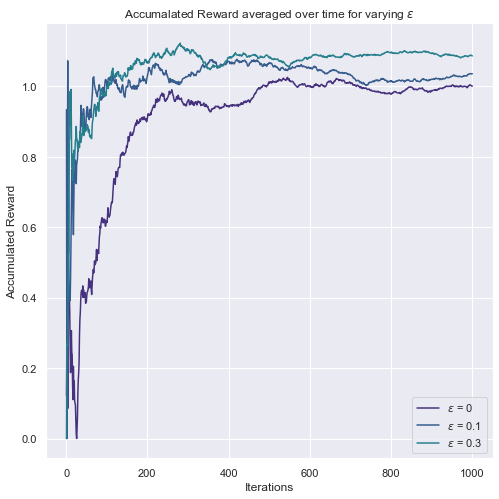

In [25]:
acc_reward_0 = eta_greedy_k_bandit_stochastic(eta=0.0, N=1000, machines=[0, 1, 2], init_value=0)
acc_reward_01 = eta_greedy_k_bandit_stochastic(eta=0.1, N=1000, machines=[0, 1, 2], init_value=0)
acc_reward_03 = eta_greedy_k_bandit_stochastic(eta=0.3, N=1000, machines=[0, 1, 2], init_value=0)
reward_comparison_plot(acc_reward_0, acc_reward_01, acc_reward_03)

## What is the impact of picking different initial values? 

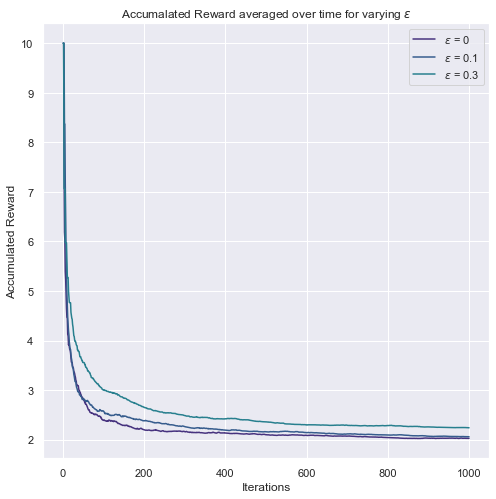

In [20]:
acc_reward_0 = eta_greedy_k_bandit_stochastic(eta=0.0, N=1000, machines=[0, 1, 2], init_value=10)
acc_reward_01 = eta_greedy_k_bandit_stochastic(eta=0.1, N=1000, machines=[0, 1, 2], init_value=10)
acc_reward_03 = eta_greedy_k_bandit_stochastic(eta=0.3, N=1000, machines=[0, 1, 2], init_value=10)
reward_comparison_plot(acc_reward_0, acc_reward_01, acc_reward_03)

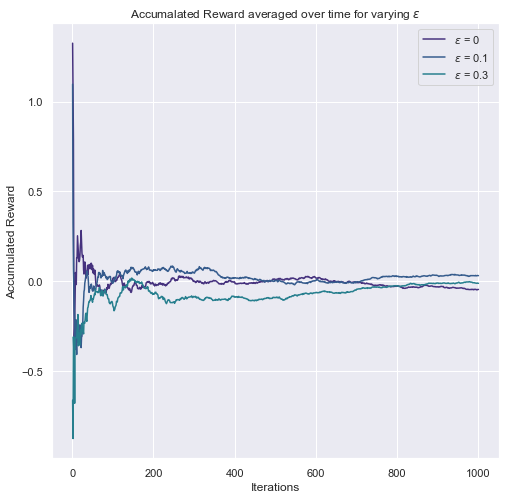

In [21]:
acc_reward_0 = eta_greedy_k_bandit_stochastic(eta=0.0, N=1000, machines=[0, 1, 2], init_value=-10)
acc_reward_01 = eta_greedy_k_bandit_stochastic(eta=0.1, N=1000, machines=[0, 1, 2], init_value=-10)
acc_reward_03 = eta_greedy_k_bandit_stochastic(eta=0.3, N=1000, machines=[0, 1, 2], init_value=-10)
reward_comparison_plot(acc_reward_0, acc_reward_01, acc_reward_03)

Depending on how close we are to the goal, the initial value can help guide and either find us the optimal solution quicker or if chosen poorly can be a trap for a sub-optimal solution.